# Preprocessing the Ames Housing Dataset

In [486]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [487]:
df = pd.read_csv("../data/Ames_Housing_Price_Data.csv")
df.drop(['Unnamed: 0'], axis=1, inplace=True)
print(f"Read Ames Housing data from csv. Shape: {df.shape}")

Read Ames Housing data from csv. Shape: (2580, 81)


## Drop duplicates

In [488]:
df[df.PID.duplicated()] # PID 909276070 is a dupe!

,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1817,909276070,1717,194000,50,RL,80.0,12400,Pave,NaN,Reg,...,113,0,NaN,NaN,NaN,0,2,2006,WD,Normal


In [489]:
df.drop_duplicates(inplace=True)

It is unclear why there is one duplicate in the dataset. I initially thought there would be many, as a property could be sold multiple times in the time span of the dataset. However, that appears not to be the case as per the creator of the dataset, Dean De Cock.

See: [http://jse.amstat.org/v19n3/decock.pdf](http://jse.amstat.org/v19n3/decock.pdf)

# Outliers
Reading De Cock's description of the dataset, we find that there are some outliers that we might want to exclude (GrLivArea > 4000)

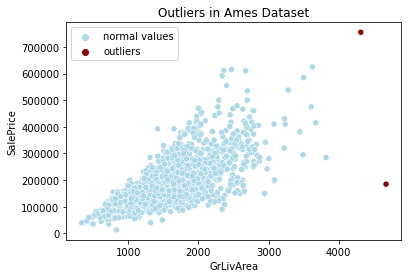

In [490]:
outliers = np.where(df.GrLivArea > 4000, "outliers", "normal values")
sns.scatterplot(x = df.GrLivArea, y = df.SalePrice, hue = outliers, palette = ["lightblue", "darkred"])
plt.title("Outliers in Ames Dataset")
plt.show()

In [491]:
# Remove large properties
df = df[df.GrLivArea < 4000]

# Missing Values
The [data description](/data/data_description.txt) tells us that several empty values actually have meaning. Here, we will replace the empty value with the meaning.
E.g., NA in the Alley columns means there is no alley for the property.

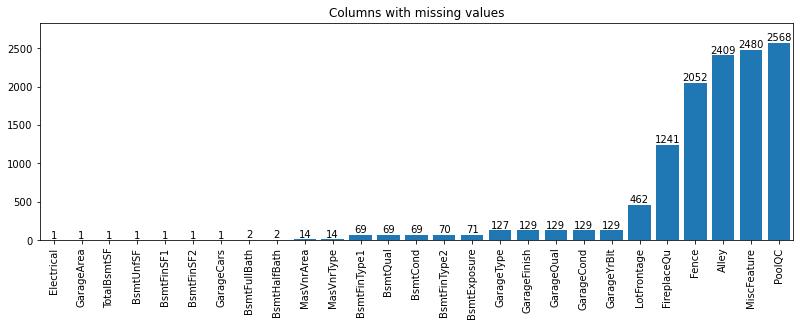

In [492]:
def show_missing(title = "Columns with missing values"):
    missing_count = df.isnull().sum()
    missing_cols = missing_count[missing_count > 0]
    if missing_cols.size == 0:
        print(f"{title}\nNo missing values")
        return
    missing_cols.sort_values(inplace=True)

    fig, ax = plt.subplots()
    missing_cols.plot.bar()
    # hackily show the missing counts; adjust width and ylim to prettify
    p = ax.bar(x = missing_cols.index, height = missing_cols.values)
    ax.bar_label(p, missing_cols.values)
    bottom, top = ax.get_ylim()
    ax.set_ylim(top=top*1.05)
    plt.title(title)
    fig = plt.gcf()
    fig.set_size_inches(len(missing_cols)/2, 4)
    plt.show()

show_missing()

In [493]:
# Replace Missing Values with their meanings. Search "NA" in data description for meanings
df.fillna(value={"Alley": "NoAlley",
                 "BsmtQual": "NoBasement",
                 "BsmtCond": "NoBasement",
                 "BsmtExposure": "NoBasement",
                 "BsmtFinType1": "NoBasement",
                 "BsmtFinType2": "NoBasement",
                 "FireplaceQu": "NoFireplace",
                 "GarageType": "NoGarage",
                 "GarageFinish": "NoGarage",
                 "GarageQual": "NoGarage",
                 "GarageCond": "NoGarage",
                 "PoolQC": "NoPool",
                 "Fence": "NoFence",
                 "MiscFeature": "NoMisc"},
          inplace=True)

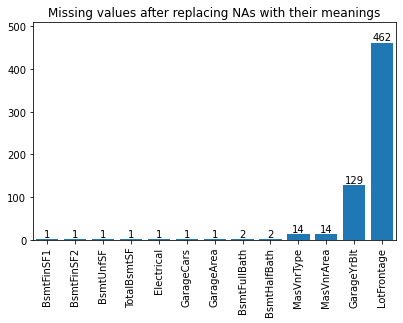

In [494]:
show_missing("Missing values after replacing NAs with their meanings")

Now that we have replaced the missing values with meanings, we can look at actual missing data and impute those

In [495]:
# A single property has a lot of missing values related to its Basement (PID 903230120)
# Another one is missing values for basement bathrooms (PID 908154080)
def get_missing_cols_for_pid(pid):
    return df[df.PID == pid].columns[df[df.PID == pid].isna().any()].tolist()

In [496]:
# We can set all of these to 0 (manually checked that 0 works for all columns)
df.loc[df.PID == 903230120, get_missing_cols_for_pid(903230120)] = 0
df.loc[df.PID == 908154080, get_missing_cols_for_pid(908154080)] = 0

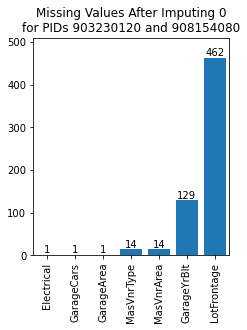

In [497]:
show_missing("Missing Values After Imputing 0\nfor PIDs 903230120 and 908154080")

In [498]:
# 916386080 is missing Electrical. Impute with mode
df.loc[df.PID == 916386080, get_missing_cols_for_pid(916386080)] = df.Electrical.mode()[0]

In [499]:
# 910201180 is missing some values (GarageYrBlt, GarageCars, GarageArea) for its detached garage
# get_missing_cols_for_PID(910201180)

# Assume garage built same year as house, set number of cars as mode and area as median of detached garages
df.loc[df.PID == 910201180, 'GarageYrBlt'] = df[df.PID == 910201180]['YearBuilt']
df.loc[df.PID == 910201180, 'GarageCars'] = df[df.GarageType == "Detchd"]['GarageCars'].mode()[0]
df.loc[df.PID == 910201180, 'GarageArea'] = df[df.GarageType == "Detchd"]['GarageArea'].median()


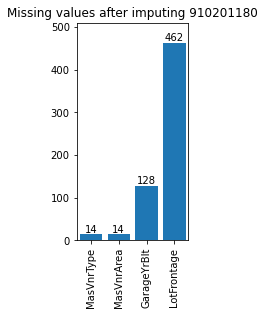

In [500]:
show_missing("Missing values after imputing 910201180")

In [501]:
# 14 values with NA for masonry. Assume None for type and 0 for area
df.fillna(value={"MasVnrType": "None", "MasVnrArea": 0}, inplace=True)

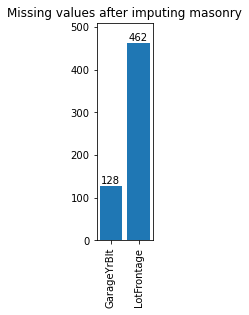

In [502]:
show_missing("Missing values after imputing masonry")

In [503]:
# Assume garage built same year as house
df['GarageYrBlt'].fillna(df.YearBuilt, inplace=True)

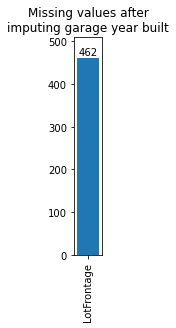

In [504]:
show_missing("Missing values after\nimputing garage year built")

In [505]:
# some addresses to check visually in a map using a ruler
geodf = pd.read_csv("../data/housing_geolocation.csv")
geodf[geodf['PID'].isin(df[df.LotFrontage.isna()]['PID'].head())]['geolocation']

0     436, Hayward Avenue, Campustown, Ames, Story C...
14    2519, Kellogg Avenue, Broadmoor, Ames, Story C...
19    2102, Prairie View East, Prairie View, Ames, S...
28    2711, Hampton Street, Somerset, Ames, Story Co...
29    1636, Johnson Street, Parkview Heights;, Ames,...
Name: geolocation, dtype: object

Using [Google Maps](https://goo.gl/maps/M7GHmawYC6p4tDgY7), we see that frontage is around
* 29 ft for 436, Hayward Avenue, Campustown
* 64 ft for 2519, Kellogg Avenue, Broadmoor
* 58 ft for 2102, Prairie View East, Prairie View
* 26 ft for 2711, Hampton Street, Somerset
* 51 ft for 1636, Johnson Street, Parkview Heights

In [506]:
# Lot frontage is the width of the lot as facing a street. It cannot be imputed as 0
# See: https://www.gimme-shelter.com/wp-content/uploads/2012/04/Frontage-of-a-Lot-in-Glenora-Edmonton1.png
# Some possible approaches:
# Assume the lot is square and impute frontage by the square root of lot area
# Impute by mean of the frontage given lot shape (we are doing this)
#   Scale the above by the lot area rather than take just the mean
# Impute by mean of frontage given lot config (values look odd, so won't do this)
# Impute by mean of frontage given neighborhood
# Impute by Google Maps approach above (not practical for number of missing values)
#   Useful to sanity check

# imputed lot frontage = round(mean of LotFrontage for property's LotShape)
# See: https://stackoverflow.com/questions/19966018/pandas-filling-missing-values-by-mean-in-each-group
df['LotFrontage'] = df.groupby('LotShape')['LotFrontage'].transform(lambda x: x.fillna(x.mean().round()))

In [507]:
show_missing("Missing values after imputing lot frontage")

Missing values after imputing lot frontage
No missing values


## Save Cleaned Data

In [508]:
df.to_csv("../data/cleaned.csv")